# Google Merchandise Store - Consumer Analysis


The dataset contains Google Analytics 360 data from the Google Merchandise Store, a real ecommerce store. The Google Merchandise Store sells Google branded merchandise. The data is typical of what you would see for an ecommerce website. It includes the following kinds of information:

 * Traffic source data: information about where website visitors originate. This includes data about organic traffic, paid search traffic, display traffic, etc. 

 * Content data: information about the behavior of users on the site. This includes the URLs of pages that visitors look at, how they interact with content, etc. 
 * Transactional data: information about the transactions that occur on the Google Merchandise Store website.


## Create the Enviroment
To connect to the google dataset we need to get access credentials to their BigQuery API then set the variable enviroment to automatic access those creditentials whenever we pull data.

In [3]:
from google.cloud import bigquery #Install google.cloud.bigquery package first
from google.oauth2 import service_account # Set up a google storage service account and download the API Key
import bq_helper # Find the bq_helper here:  https://github.com/SohierDane/BigQuery_Helper/blob/master/bq_helper.py
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Instructions to get access credentials here: https://www.blendo.co/blog/access-data-google-bigquery-python-r/


# Set Variable Enviroment to the downloaded API Key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:\\Users\\conra\programs_ct\\IST_652-2a069892d27e.json"

# Test Variable Enviroment any output = Success
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)
implicit()



[]


### Connect to the dataset and text the connection

In [4]:
# Create a BQ_Helper Object for data scanning
google_analytics = bq_helper.BigQueryHelper( active_project= "bigquery-public-data",  dataset_name="google_analytics_sample")

# Create list of tables to later assist with queries
tablelist = google_analytics.list_tables()
print(len(tablelist))
print("First table:", tablelist[0],"  Last table:", tablelist[-1])

366
First table: ga_sessions_20160801   Last table: ga_sessions_20170801


In [5]:
# Preview the First few rows of a table
google_analytics.head('ga_sessions_20170801', num_rows=3)

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,None,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged
1,None,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8647436381089107732,None,None,Organic Search,Not Socially Engaged
2,None,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2055839700856389632,None,None,Organic Search,Not Socially Engaged


In [6]:
# Check structure of fields in 'ga_sessions_20170701' table
schema = google_analytics.table_schema('ga_sessions_20170701')
print(schema.shape)
schema.head()

(338, 4)


,name,type,mode,description
0,visitorId,INTEGER,NULLABLE,None
1,visitNumber,INTEGER,NULLABLE,None
2,visitId,INTEGER,NULLABLE,None
3,visitStartTime,INTEGER,NULLABLE,None
4,date,STRING,NULLABLE,None


## Transactional Analysis
We will start by querying the transaction data set to answer questions about purchases. Such as which countries bring in the most total revenue -

In [7]:
# Query each country's revenue from August 2016 to July 2017
query = """
  SELECT
      geoNetwork.country AS country,
      SUM(totals.totalTransactionRevenue)/1e6 AS revenue
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
      _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
      AND totals.totalTransactionRevenue IS NOT NULL
  GROUP BY
      1
  ORDER BY
      2 DESC
"""

global_revenue = google_analytics.query_to_pandas_safe(query)
print(global_revenue.shape)
global_revenue.head(10)

(69, 2)


,country,revenue
0,United States,1655376.71
1,Venezuela,36082.25
2,Canada,34921.89
3,Japan,7629.13
4,Kenya,5285.70
5,Nigeria,3314.40
6,Indonesia,2678.14
7,Taiwan,2015.89
8,United Kingdom,1962.36
9,Australia,1811.26


### Page Views 
We can see the page views by purchasing customers and non purchasing customers

In [8]:
query = """
  SELECT
      CASE WHEN totals.totalTransactionRevenue IS NULL THEN 'FALSE'
          ELSE 'TRUE' END AS PurchaseStatus
      , AVG(totals.pageviews) AS PageViews 
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
      _TABLE_SUFFIX BETWEEN '20170701' AND '20170730'
      AND geoNetwork.country = 'United States'    
  GROUP BY
      1
"""

pageviewsBypurchase = google_analytics.query_to_pandas_safe(query)
print(pageviewsBypurchase .shape)
pageviewsBypurchase .head(3)

(2, 2)


,PurchaseStatus,PageViews
0,FALSE,4.167571
1,TRUE,25.673118


### Browser and Bounce Rate
We can pivot the page view and revenue data by browser type to see how each browser preforms. We get the bounce rate by calculating the portion of visits that have only one page view.

In [9]:
query = """
  SELECT 
      device.browser AS browser
      , Count(fullVisitorId) TotalVistorSessions
      , ROUND((SUM(CASE WHEN totals.pageviews > 1 THEN 0 ELSE 1 END)/Count(fullVisitorId))*100, 2) AS BounceRate
      , SUM(totals.transactions) NumberOfTransactions
      , SUM(totals.TransactionRevenue) As Revenue
      , ROUND((SUM(totals.TransactionRevenue) / SUM(totals.transactions)), 2) AS AVG_Purchase
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
      _TABLE_SUFFIX BETWEEN '20170701' AND '20170730'
      AND geoNetwork.country = 'United States'     
  GROUP BY
      1
  ORDER BY 
      Count(fullVisitorId) DESC    

"""  

bounceRatebyDevice = google_analytics.query_to_pandas_safe(query)
print(bounceRatebyDevice.shape)
bounceRatebyDevice.head(5)

(21, 6)


,browser,TotalVistorSessions,BounceRate,NumberOfTransactions,Revenue,AVG_Purchase
0,Chrome,22024,36.11,893.0,1.040594e+11,1.165279e+08
1,Safari,7268,47.98,60.0,2.124960e+09,3.541600e+07
2,Firefox,551,47.55,9.0,3.160400e+08,3.511556e+07
3,Edge,542,54.24,2.0,8.466000e+07,4.233000e+07
4,Internet Explorer,412,58.50,4.0,4.523800e+08,1.130950e+08


## Consumer Behavior Analysis 
We will now focus on consumer behavior in the merchandise store. This presents some challenges because visitors can buy items at the first visit, but also they can look around the site multiple times through different channels until purchase.
Because of this we need to examine the number of visits and the period from visit to purchase instead of acquisition channel. We'll call this duration period_days below

In [10]:
# Query number of visits and period based on visitor id and purchase record
query = """
  WITH us_april AS (
      SELECT
          fullVisitorId AS user_id,
          visitId AS visit_id,
          TIMESTAMP_SECONDS(visitStartTime) AS visit_time,
          CASE
            WHEN totals.transactions >= 1 THEN 1
            ELSE 0
          END AS transaction,
          totals.visits AS visit,
          trafficSource.medium AS medium,
          trafficSource.source AS source,
          IFNULL(totals.totalTransactionRevenue, 0)/1e6 AS session_revenue
      FROM
          `bigquery-public-data.google_analytics_sample.ga_sessions_*`
      WHERE
          _TABLE_SUFFIX BETWEEN '20170701' AND '20170730'
          AND geoNetwork.country = 'United States')

  SELECT
      user_id,
      prev_purchase_record,
      ARRAY_AGG(visit_id) AS visit_id,
      ARRAY_AGG(visit_time) AS visit_time,
      STRING_AGG(medium, " > ") AS medium_path,
      SUM(visit) AS total_visits,
      TIMESTAMP_DIFF(MAX(visit_time), MIN(visit_time), DAY) AS period_day,
      SUM(transaction) AS conversion,
      MAX(session_revenue) AS total_revenue
  FROM
      (SELECT
         *,
         IFNULL(
           SUM(transaction) OVER (
             PARTITION BY user_id
             ORDER BY visit_time
             ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)
         , 0) AS prev_purchase_record
       FROM
          us_april)
  GROUP BY
      1, 2
"""

visit_behavior = google_analytics.query_to_pandas_safe(query)
print(visit_behavior.shape)
visit_behavior.head(3)

(24520, 9)


,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue
0,0133997037145648015,0,"[1499841227, 1499991732, 1499991939]","[2017-07-12 06:33:47+00:00, 2017-07-14 00:22:1...",(none) > (none) > referral,3,1,0,0.0
1,0365566672811954105,0,"[1501185079, 1501354396]","[2017-07-27 19:51:19+00:00, 2017-07-29 18:53:1...",referral > referral,2,1,0,0.0
2,086743172005839366,0,"[1499980989, 1501181899]","[2017-07-13 21:23:09+00:00, 2017-07-27 18:58:1...",cpc > cpm,2,13,0,0.0


### Unesting Visit Behavior Data
Dataframe 'visit_behavior' contains data based on user and previous purchase record Visit data of users with multiple visits is stored in nested form. To utilize visit data, we need to unnest the data.

In [11]:

# Unnest visit_id
visitId_unnest = pd.DataFrame({'visit_id': np.concatenate(visit_behavior.visit_id.values)},
                               visit_behavior.index.repeat(visit_behavior.visit_id.str.len()))
# Unnest visit_time
visitTime_unnest = pd.DataFrame({'visit_time': np.concatenate(visit_behavior.visit_time.values)}
                                , visit_behavior.index.repeat(visit_behavior.visit_time.str.len()))
# Put tables back together
behavior_unnest = pd.concat([visitId_unnest, visitTime_unnest], axis=1, join='inner') \
                    .join(visit_behavior.drop(['visit_id','visit_time'], axis=1), how='left') \
                    .reindex(columns=visit_behavior.columns)

print(behavior_unnest.shape)
behavior_unnest.head()

(31330, 9)


,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue
0,0133997037145648015,0,1499841227,2017-07-12 06:33:47+00:00,(none) > (none) > referral,3,1,0,0.0
0,0133997037145648015,0,1499991732,2017-07-14 00:22:12+00:00,(none) > (none) > referral,3,1,0,0.0
0,0133997037145648015,0,1499991939,2017-07-14 00:25:39+00:00,(none) > (none) > referral,3,1,0,0.0
1,0365566672811954105,0,1501185079,2017-07-27 19:51:19+00:00,referral > referral,2,1,0,0.0
1,0365566672811954105,0,1501354396,2017-07-29 18:53:16+00:00,referral > referral,2,1,0,0.0


### One Time Visters
We will now extract and analyze specifically those users who only visits the website one time to see what we can learn from their path and behavior 

In [12]:
# Extract data of 'OneTimeVisits'
visit = (behavior_unnest.total_visits == 1)
period = (behavior_unnest.period_day == 0)

OneTimeVisits = behavior_unnest[visit & period].copy()
print(OneTimeVisits.shape)
OneTimeVisits.head(3)

(20599, 9)


,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue
1355,068936166799742560,0,1501345151,2017-07-29 16:19:11+00:00,cpc,1,0,0,0.0
1356,1624879573179778729,0,1498945442,2017-07-01 21:44:02+00:00,cpc,1,0,0,0.0
1357,2813763471855219693,0,1499004533,2017-07-02 14:08:53+00:00,cpc,1,0,0,0.0


### One Time Visits Revenue and Traffic Analysis

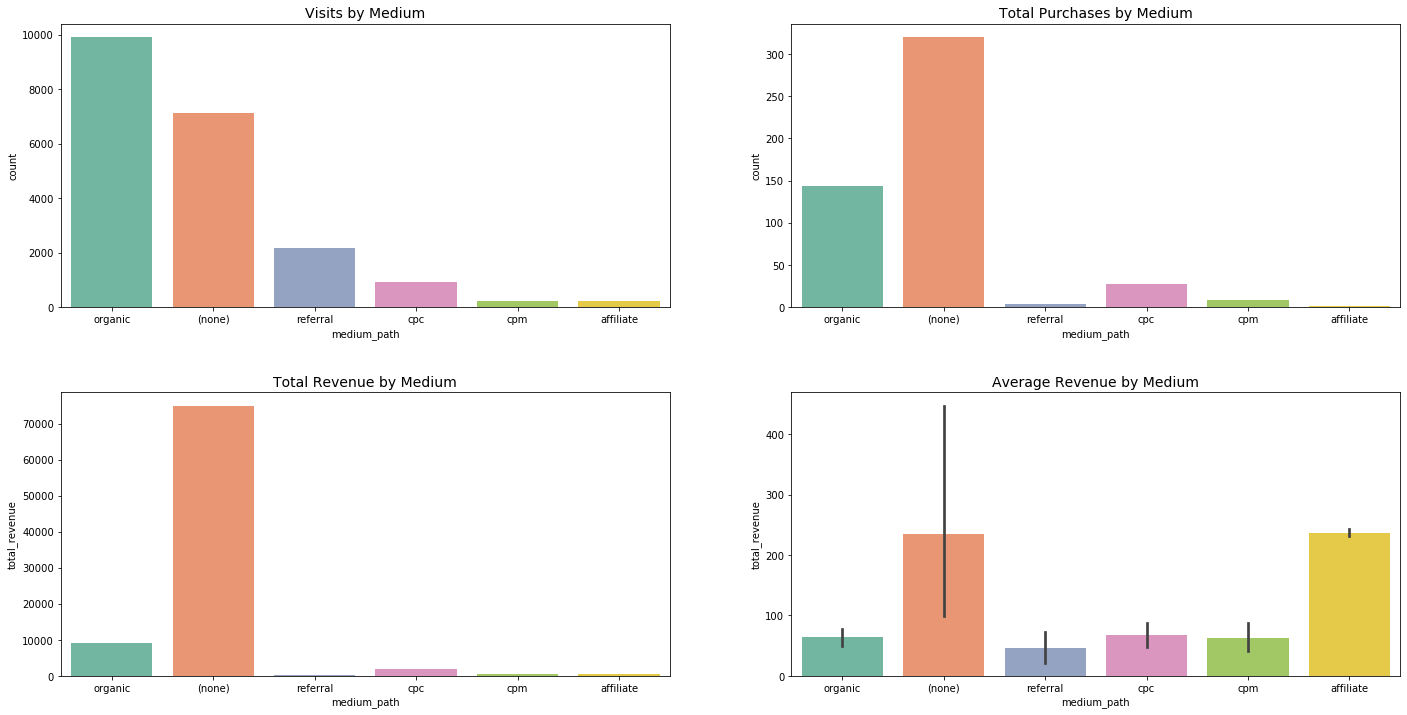

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24,12))
fig.subplots_adjust(hspace=0.3)

OneTime_conversion = OneTimeVisits[OneTimeVisits.conversion == 1]

sns.countplot(x='medium_path',
              data=OneTimeVisits,
              order=OneTimeVisits.medium_path.value_counts().index,
              palette="Set2",
              ax=ax1)
sns.countplot(x='medium_path',
              data=OneTime_conversion,
              order=OneTimeVisits.medium_path.value_counts().index,
              palette="Set2",
              ax=ax2)
sns.barplot(x='medium_path',
            y='total_revenue',
            data=OneTime_conversion,
            order=OneTimeVisits.medium_path.value_counts().index,
            palette="Set2",
            estimator=sum,
            ci=None,
            ax=ax3)
sns.barplot(x='medium_path',
            y='total_revenue',
            data=OneTime_conversion,
            order=OneTimeVisits.medium_path.value_counts().index,
            palette="Set2",
            ax=ax4)

ax1.set_title('Visits by Medium',
              fontsize=14)
ax2.set_title('Total Purchases by Medium',
              fontsize=14)
ax3.set_title('Total Revenue by Medium',
              fontsize=14)
ax4.set_title('Average Revenue by Medium',
              fontsize=14);

"None" refers to direct traffic. Here it is the largest contributor of both purchase and revenue.
Though organic generated the most traffic, its revenue is about one half of revenue of "none".

Cpc and cpm produced purchases with greater revenue than organic or (none). By reviewing top-performing ads, we can check whether there is an unrecognized opportunity.






### Querying the Action Data
We now will pull in the action data to review what actions every session resulted in below you can see the nine categories of actions. We will then join this data to the One Time Visits dataset.

In [14]:
# Query key actions of the entire sessions of July 2017 in the US

query = """
  SELECT
    CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS unique_session_id,
    device.deviceCategory AS device_category,
    trafficSource.medium,
    IFNULL(totals.bounces, 0) AS bounce,
    CAST(hits.eCommerceAction.action_type AS INT64) AS action,
    CASE hits.eCommerceAction.action_type
      WHEN '0' THEN 'visit'
      WHEN '1' THEN 'product_list'
      WHEN '2' THEN 'product_detail'
      WHEN '3' THEN 'add_to_cart'
      WHEN '4' THEN 'remove_from_cart'
      WHEN '5' THEN 'checkout'
      WHEN '6' THEN 'order_complete'
      WHEN '7' THEN 'refund'
      WHEN '8' THEN 'checkout_options'
    END AS action_desc
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    , UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170730'
    AND geoNetwork.country = 'United States'
"""

site_action = google_analytics.query_to_pandas_safe(query)
print(site_action.shape)
site_action.head(3)

(182550, 6)


,unique_session_id,device_category,medium,bounce,action,action_desc
0,87618154865998551701500267001,desktop,organic,0,0,visit
1,87618154865998551701500267001,desktop,organic,0,0,visit
2,87618154865998551701500267001,desktop,organic,0,0,visit


In [15]:
#Join 'OneTimeVisits' to 'site_action'

# Remove rows with duplicate 'user id' and 'action'
site_action = site_action.drop_duplicates(subset=['unique_session_id', 'action'])
site_action.shape

# Create a key column in 'OneTimeVisits'
OneTimeVisits.visit_id = OneTimeVisits.visit_id.astype(str)
 
OneTimeVisits['unique_session_id'] = OneTimeVisits['user_id'] + OneTimeVisits['visit_id']

# Use Panda Merge to JOIN The Tables
OneTime_action = pd.merge(OneTimeVisits,
                        site_action,
                        how='inner',
                        on='unique_session_id')
print(OneTime_action.shape)
OneTime_action.head(3)

(30045, 15)


,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue,unique_session_id,device_category,medium,bounce,action,action_desc
0,068936166799742560,0,1501345151,2017-07-29 16:19:11+00:00,cpc,1,0,0,0.0,0689361667997425601501345151,mobile,cpc,1,0,visit
1,1624879573179778729,0,1498945442,2017-07-01 21:44:02+00:00,cpc,1,0,0,0.0,16248795731797787291498945442,mobile,cpc,1,0,visit
2,2813763471855219693,0,1499004533,2017-07-02 14:08:53+00:00,cpc,1,0,0,0.0,28137634718552196931499004533,mobile,cpc,0,0,visit


### Funnel Analysis
We can now preform a funnel analysis to see where we are losing customers along the purchase process 

In [16]:
# Funnel Analysis 

OneTime_action_none = OneTime_action[OneTime_action['medium'] == '(none)']

funnel = pd.pivot_table(OneTime_action_none,
                        index='action_desc',
                        values='unique_session_id',
                        aggfunc='count')

# A few sessions do not start their actions from zero ('visit')
# Thus we need to adjust total number of visits
funnel.loc['visit'] = len(OneTime_action_none.groupby('unique_session_id'))
funnel.loc['non_bounce'] = (len(OneTime_action_none.groupby('unique_session_id'))
                            - len(OneTime_action_none[OneTime_action_none['bounce'] == 1]))
    
funnel_index = ['visit', 'non_bounce', 'product_list',
                'product_detail', 'add_to_cart',
                'checkout', 'order_complete']

funnel = funnel.reindex(funnel_index)
funnel

,unique_session_id
action_desc,
visit,7131
non_bounce,4242
product_list,1282
product_detail,1279
add_to_cart,626
checkout,413
order_complete,320


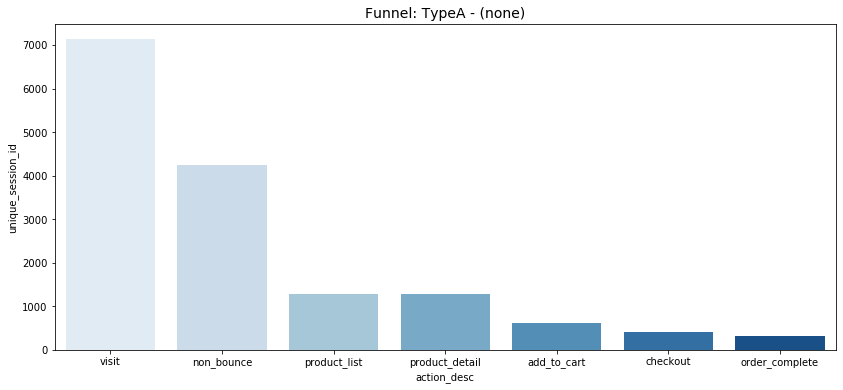

In [17]:
# Plot the funnel
fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(x=funnel.index,
            y='unique_session_id',
            data=funnel,
            palette="Blues",
            ax=ax)

ax.set_title('Funnel: TypeA - (none)',
             fontsize=14);

Conversion rate from non-bounced visit to product list view is the lowest. Let's check out if a difference exists among device category.

### Preprocess Data to Seperate by device
Use the pandas pivot function to group the actions by device type.
Then sum and group the visit and non-bounce counts by tupling them with the device type. 

In [18]:
# Pivot the Funnel table by Device

funnel_device = pd.pivot_table(OneTime_action_none,
                               index=['action_desc', 'device_category'],
                               values='unique_session_id',
                               aggfunc='count')
funnel_device.loc['visit']

# Adjust number of visits
visit = OneTime_action_none.groupby(['unique_session_id', 'device_category']) \
                         .visit_id \
                         .count() \
                         .unstack(1, fill_value=0)

visit = visit.applymap(lambda x: 1 if x >=1 else 0) \
             .sum() \
             .values

tuples= [('visit', 'desktop'), ('visit', 'mobile'), ('visit', 'tablet')]
index = pd.MultiIndex.from_tuples(tuples, names=['action_desc', 'device_category'])

visit = pd.Series(visit, index=index) \
          .to_frame() \
          .rename(columns={0: 'unique_session_id'})

funnel_device.loc['visit'] = visit
funnel_device.loc['visit']

# Add 'non_bounce' stage
bounce = OneTime_action_none[OneTime_action_none['bounce'] == 1] \
                          .groupby(['unique_session_id', 'device_category']) \
                          .visit_id \
                          .count() \
                          .unstack(1, fill_value=0)

bounce = bounce.sum().values
tuples = [('non_bounce', 'desktop'), ('non_bounce', 'mobile'), ('non_bounce', 'tablet')]
index = pd.MultiIndex.from_tuples(tuples, names=['action_desc', 'device_category'])

bounce = pd.Series(bounce, index=index) \
           .to_frame() \
           .rename(columns={0: 'unique_session_id'})

non_bounce = funnel_device.loc['visit'] - bounce
funnel_device = pd.concat([funnel_device, non_bounce])
funnel_device.head

<bound method NDFrame.head of                                   unique_session_id
action_desc      device_category                   
add_to_cart      desktop                        566
                 mobile                          49
                 tablet                          11
checkout         desktop                        384
                 mobile                          25
                 tablet                           4
order_complete   desktop                        306
                 mobile                          11
                 tablet                           3
product_detail   desktop                       1086
                 mobile                         174
                 tablet                          19
product_list     desktop                       1088
                 mobile                         175
                 tablet                          19
remove_from_cart desktop                        161
                 mobile           

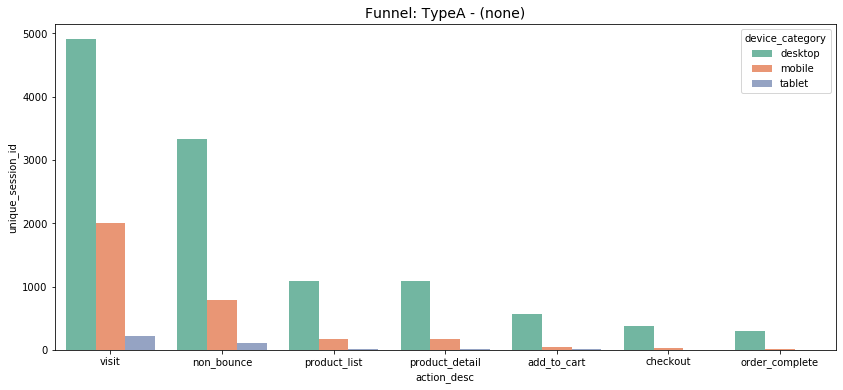

In [19]:
# Plot the funnel by device category
funnel_device_index = ['visit', 'non_bounce', 'product_list',
                       'product_detail', 'add_to_cart',
                       'checkout', 'order_complete']

funnel_device_plot = funnel_device.unstack() \
                                  .reindex(funnel_device_index) \
                                  .stack() \
                                  .reset_index()

fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(x='action_desc',
            y='unique_session_id',
            hue='device_category',
            data=funnel_device_plot,
            palette='Set2',
            ax=ax)

ax.set_title('Funnel: TypeA - (none)',
             fontsize=14);

Three categories have product list view as a common weak point where visitors exited funnels most often. That means improvement of the stage can lead to the greatest impact on purchase rate. To find possible explanations for this behavior we will examine site engagement.

Site Engagement by Funnel Stage

# Site Engagement
In order to analyze site engagment we need to look at a customers path across the site. To do this we will query the page titles of the their path as well as their time spent. We will then join this table to the information previously gathered about customer actions. For this analysis we will specifically target one time vistors that came  via direct traffic. 

In [20]:
# Preprocessing

# Query time spent on site/page and page info by session
query = """
  SELECT
      CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS unique_session_id,
      totals.timeOnSite,
      hits.time/1000 AS hitTime_sec,
      LAST_VALUE(hits.time/1000) OVER (
        PARTITION BY CONCAT(fullVisitorId, CAST(visitId AS STRING))
        ORDER BY hits.time/1000 
        ROWS BETWEEN CURRENT ROW AND 1 FOLLOWING
        ) - (hits.time/1000) AS stayingTime_sec,
      hits.page.pageTitle AS page_title,
      hits.page.pagePath AS page_path
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
      , UNNEST(hits) AS hits
  WHERE
      _TABLE_SUFFIX BETWEEN '20170701' AND '20170730'
      AND geoNetwork.country = 'United States'
      AND hits.type = 'PAGE'
"""

engagement = google_analytics.query_to_pandas_safe(query)
print(engagement.shape)


# Bring the dataframe containing key actions of one time from (none)
OneTime_action_none = OneTime_action_none.sort_values(['unique_session_id', 'action'],
                                                  ascending=[True, False])

# Leave only one row of a session with the last action
# for computation of site engagement at each funnel stage
OneTime_action_none_unique = OneTime_action_none.drop_duplicates(subset='unique_session_id')
print(OneTime_action_none_unique.shape)


# Join the above OneTime dataframe to engagement
OneTime_none_engagement = pd.merge(OneTime_action_none_unique,
                                 engagement,
                                 how='inner',
                                 on='unique_session_id')
print(OneTime_none_engagement.shape)


# To clearly compare engagement of product discovery between funnel stages
# leave out checkout pages.
checkout_page = ['/yourinfo.html', '/payment.html',
                 '/revieworder.html', '/ordercompleted.html']

# To make variable name simple, use the abbreviations below
# O: One Time N: (none) E: engagement
ONE_discovery = OneTime_none_engagement[~OneTime_none_engagement['page_path'] \
                                      .isin(checkout_page)]
ONE_discovery.shape

# Summarize engagement of every session
ONE_discovery_summary = ONE_discovery.groupby('unique_session_id') \
                                     .agg({'device_category': 'first',
                                           'prev_purchase_record': 'first',
                                           'action_desc': 'first',
                                           'bounce': 'first',
                                           'conversion': 'first',
                                           'page_path': 'count',
                                           'stayingTime_sec': sum})
ONE_discovery_summary.head(3)

(150541, 6)
(7131, 15)
(33975, 20)


,device_category,prev_purchase_record,action_desc,bounce,conversion,page_path,stayingTime_sec
unique_session_id,,,,,,,
00000850598281732121500505105,mobile,0,visit,1,0,1,0.000
00005724341422654651500605115,desktop,0,visit,0,0,3,66.132
0001701871706731771501020630,desktop,0,visit,0,0,4,40.865


### Page Sequence
Now we can see page path of non-bounced visits. 

In [21]:
# Extract non-bounced visits
visit = (ONE_discovery['action_desc'] == 'visit')
non_bounce = (ONE_discovery['bounce'] == 0)

ONE_discovery_nonbounce = ONE_discovery[visit & non_bounce]
ONE_discovery_nonbounce.head(3)

# Add a column indicating page sequence
ONE_discovery_nonbounce = ONE_discovery_nonbounce \
                           .sort_values(['user_id', 'prev_purchase_record',
                                         'visit_time', 'hitTime_sec'],
                                        ascending=[True, True, True, True])

ONE_discovery_nonbounce['page_sequence'] = ONE_discovery_nonbounce \
                                            .groupby(['user_id', 'prev_purchase_record',
                                                      'visit_time']) \
                                            .cumcount() + 1

ONE_discovery_nonbounce[['unique_session_id', 'page_path', 'page_sequence']].head(10)

,unique_session_id,page_path,page_sequence
1,00005724341422654651500605115,/home,1
2,00005724341422654651500605115,/google+redesign/bags,2
3,00005724341422654651500605115,/google+redesign/apparel/mens/mens+outerwear,3
4,0001701871706731771501020630,/home,1
5,0001701871706731771501020630,/google+redesign/accessories/fun,2
6,0001701871706731771501020630,/google+redesign/office/office+other,3
7,0001701871706731771501020630,/google+redesign/accessories/fun,4
8,00038293801671404081501288488,/home,1
9,00038293801671404081501288488,/home,2
10,00038293801671404081501288488,/google+redesign/bags/backpacks/home,3


We can now group by userID and get counts of specific page views.

In [22]:
# Create a list of the upper quartile
nonbounce_pageviews = ONE_discovery_nonbounce.groupby(['unique_session_id']) \
                                             .page_sequence \
                                             .max().to_frame()

pageviews_75p = list(nonbounce_pageviews[nonbounce_pageviews['page_sequence'] <= 5].index)

# Extract non-bounced visits of the upper quartile
ONE_nonbounce_pageviews_75p = ONE_discovery_nonbounce[ONE_discovery_nonbounce['unique_session_id'].isin(pageviews_75p)]

# List the top 10 frequent page sequences
nonbounce_75p_pageSequence = ONE_nonbounce_pageviews_75p.groupby(['unique_session_id']) \
                                                        .page_path \
                                                        .agg(' > '.join) \
                                                        .value_counts() \
                                                        .to_frame()

nonbounce_75p_pageSequence['ratio(%)'] = ((nonbounce_75p_pageSequence
                                          / nonbounce_75p_pageSequence.sum())
                                          * 100).round(1)
nonbounce_75p_pageSequence.head(10)

,page_path,ratio(%)
/home > /home,159,6.9
/signin.html > /myaccount.html?mode=vieworder > /myaccount.html?mode=vieworderdetail,78,3.4
/home > /google+redesign/apparel/mens/mens+t+shirts,57,2.5
/home > /asearch.html,54,2.3
/home > /google+redesign/electronics,54,2.3
/home > /google+redesign/bags/backpacks/home,35,1.5
/home > /home > /home,34,1.5
/home > /google+redesign/drinkware,34,1.5
/home > /google+redesign/bags,26,1.1
/home > /google+redesign/apparel/mens,22,0.9


### Path Analysis

We can see that some common pattern of customer paths here included repeated home visits, search, and merchandise categories. Though the categories still have a low percentage of the total paths. 

In [23]:
# Top 10 Most Viewed Pages of Non-bounced Visits (75th Percentile of pageviews)

nonbounce_75p_page = ONE_nonbounce_pageviews_75p['page_path'].value_counts() \
                                                             .to_frame()

nonbounce_75p_page['ratio(%)'] = ((nonbounce_75p_page
                                  / nonbounce_75p_page.sum())
                                  * 100).round(1)
nonbounce_75p_page.head(10)

,page_path,ratio(%)
/home,2533,37.2
/asearch.html,346,5.1
/signin.html,329,4.8
/google+redesign/electronics,236,3.5
/google+redesign/apparel/mens/mens+t+shirts,222,3.3
/google+redesign/shop+by+brand/youtube,200,2.9
/myaccount.html?mode=vieworder,168,2.5
/myaccount.html?mode=vieworderdetail,132,1.9
/google+redesign/bags/backpacks/home,123,1.8
/google+redesign/bags,114,1.7


# Conclusion

After reviewing the data I believe that there might be three types of behavior.
#### Behavior One
In regard to ‘view order’ pages on both lists, it seems visitors may come to the site for checking their order status.
#### Behavior Two
Staying on ‘home’ pages consecutively might be visits to see if a new product or promotion launches. Similarly visiting category pages through ‘home’ might be sessions to check new products. It is worth noting that a single product page is not in the top 10 page list and upper quartile of pageviews is five. Considering two points, the store needs to attract customer’s attention at a category level.
#### Behavior Three
On-site search page is included in both lists. The sequence of ‘/home > /asearch.html’ tells us visitors may not enjoy shopping or repeat customers may directly go to product pages. In the former case, search terms can give us hints on how to improve site experience. The latter implies the site needs additional measures to attract customer's attention for upselling or cross-selling. Further, the fact that on-site search page is one of the most viewed pages means there could be visitors who fail to find what they want at once. In this case, search terms can also indicate where to improve for better user experience.